### Import the Libraries

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

# NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add,Concatenate,Reshape, Bidirectional

# Model creation Imports
from tensorflow.keras.models import Sequential, Model

# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

# Model Learning & Losses imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warning and Visualization Imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

### Load the Dataset

In [5]:
image_path ='/kaggle/input/flickr8k/Images'
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Visualization: Image and their corresponding captions

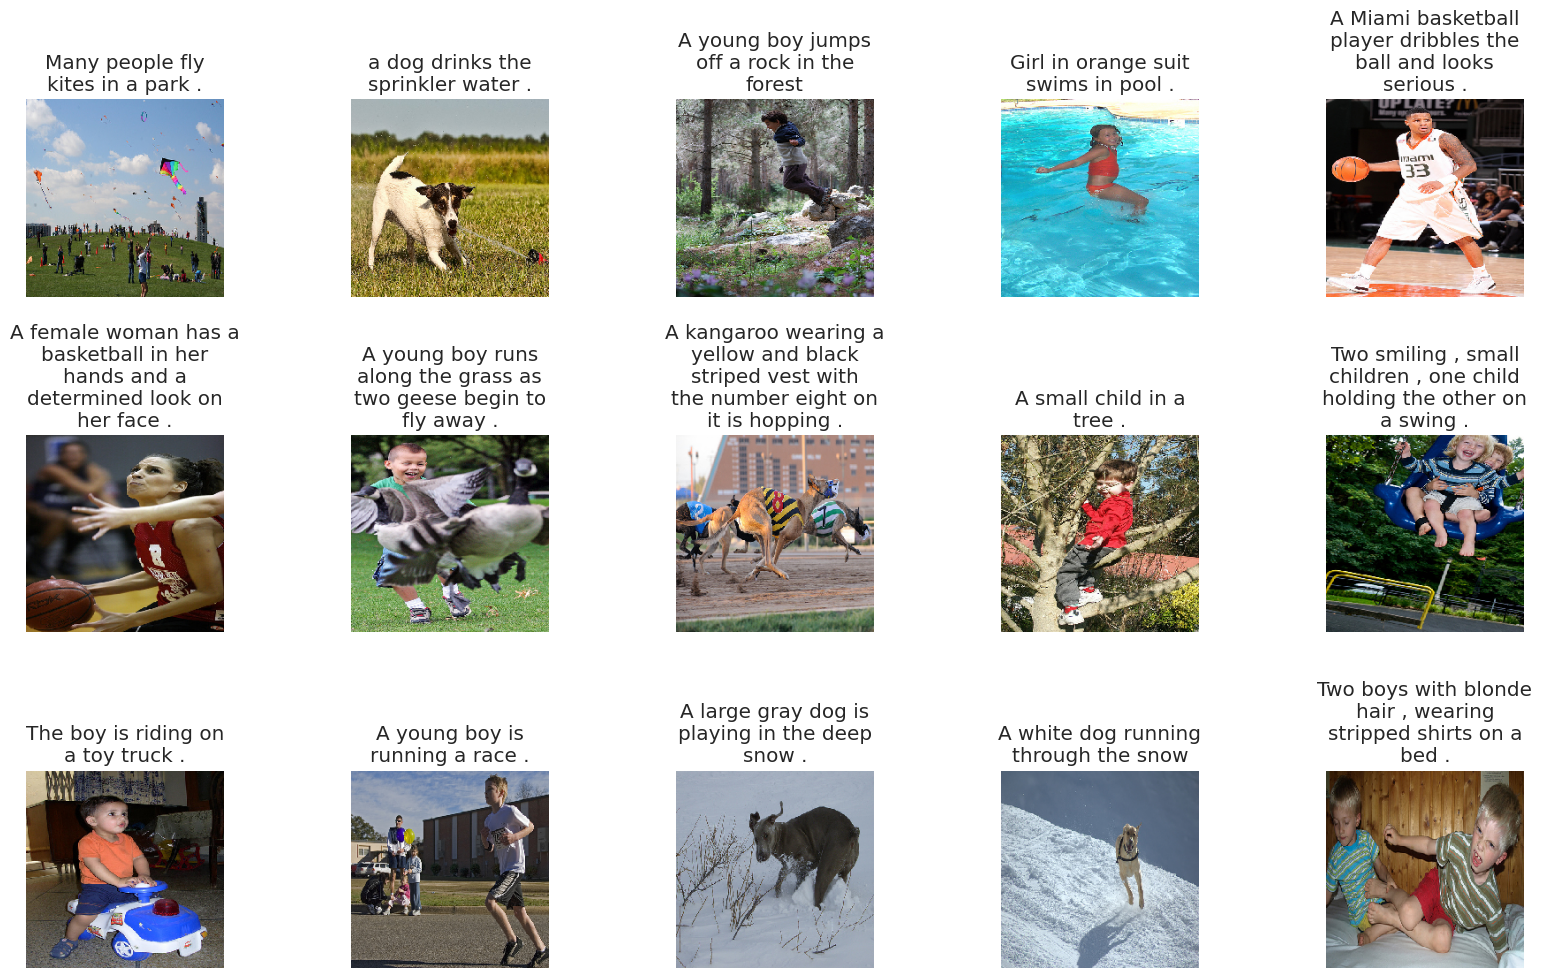

In [6]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img


def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image=readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

### Caption text Processing

In [7]:
def text_preprocessing(data):
    data['caption']=data['caption'].apply(lambda x: x.lower())
    data['caption']=data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption']=data['caption'].apply(lambda x: x.replace("\s+", ""))
    data['caption']=data['caption'].apply(lambda x: "".join([word for word in x.split() if len(word)>1]))
    data['caption']="startseq "+data['caption']+" endseq"
                                          
    return data                                      

data= text_preprocessing(data)

In [8]:
data['caption'][0]

'startseq childinpinkdressisclimbingupsetofstairsinanentryway endseq'

In [9]:
captions=data['caption'].tolist()

In [10]:
captions[:10]

['startseq childinpinkdressisclimbingupsetofstairsinanentryway endseq',
 'startseq girlgoingintowoodenbuilding endseq',
 'startseq littlegirlclimbingintowoodenplayhouse endseq',
 'startseq littlegirlclimbingthestairstoherplayhouse endseq',
 'startseq littlegirlinpinkdressgoingintowoodencabin endseq',
 'startseq blackdogandspotteddogarefighting endseq',
 'startseq blackdogandtri-coloreddogplayingwitheachotherontheroad endseq',
 'startseq blackdogandwhitedogwithbrownspotsarestaringateachotherinthestreet endseq',
 'startseq twodogsofdifferentbreedslookingateachotherontheroad endseq',
 'startseq twodogsonpavementmovingtowardeachother endseq']

In [11]:
len(captions)

40455

### Tokenization

In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1
max_length=max(len(caption.split()) for caption in captions)

images=data['image'].unique().tolist()
n_images=len(images) 

In [13]:
split_index=round(0.85*n_images)
train_images=images[:split_index]
val_images=images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[1]])[0] 

[1, 362, 2]

## Image Feature Extraction

### *DenseNet-201* 
(Dense Convolutional Network) is a deep learning architecture introduced in 2017, where each layer is connected to every preceding layer in a feed-forward manner. This dense connectivity allows for better gradient flow during training, encourages feature reuse, and reduces redundancy, making the network more parameter-efficient compared to traditional deep CNNs.
DenseNet-201, a specific variant with 201 layers, is widely used for image classification and transfer learning, often leveraging ImageNet pre-trained weights. Its architecture consists of an initial convolution layer, followed by four dense blocks separated by transition layers, and ends with a classification layer. This design enables the network to retain and propagate useful features effectively, improving learning and performance across various tasks.

In [14]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size=224
features={}

for image in tqdm(data['image'].unique().tolist()):
    img=load_img(os.path.join(image_path, image),target_size=(img_size,img_size))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img, axis=0)
    feature=fe.predict(img, verbose=0)
    features[image]=feature

I0000 00:00:1755108976.415338      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1755108993.404664     120 service.cc:148] XLA service 0x7803ac004290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755108993.405670     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755108995.896431     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755109010.697408     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [17:09<00:00,  7.86it/s]
